<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 7 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 23 February 2023</div>

# Data Science with Bayesian Estimation

[Bayesian estimation](https://en.wikipedia.org/wiki/Bayes_estimator) is practical and effective today thanks to modern implementations of [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithms implemented in popular libraries like `PyMC3`, `Sampyl`, `Stan`, `sklearn`, and others. 

Let's learn about the history of these techniques, and try out another Bayesian estimation library, `Sampyl`.

# 1. Frequentist statistics
Dominant school of statistics in the 20th century use techniques like p-values, t-tests, χ2 tests, confidence intervals, etc.

They define probability as a long-term frequency in a repeatable random experiment.

A **statistic** is anything that can be computed from random data. Examples of point statistics include data mean, data maximum, data minimum, data standard variation, and other such **moments**.

A statistic cannot be the *true* value of an unknown parameter.

A statistic can be a *hypothesized* value of a parameter.

Suppose $x_1, \cdots , x_n$ is a sample from $N(µ, σ2)$, where $µ$ and $σ$ are unknown.

Questions: Is each of the following a **statistic**?

1. The median of $x_1, \cdots , x_n$.
2. The interval from the 0.25 quantile to the 0.75 quantile of $N(µ, σ2)$.
3. The standardized mean $(x¯−µ) / (σ/√n)$.
4. The set of sample values less than 1 unit from $\bar{x}$.

Answers:

1. Yes. The median only depends on the data $x_1, \cdots , x_n$.
2. No. This interval depends only on the distribution parameters µ and σ. It does not consider the data at all.
3. No. this depends on the values of the unknown parameters µ and σ.
4. Yes. ¯x depends only on the data, so the set of values within 1 of ¯x can all be found by working with the data.

The procedure for classical statistics is the following: Formulate a Null hypothesis: H0. Formulate an alternative hypothesis: HA. For a Test statistic: x, Null hypothesis says it looks like the same statistic as a reference distribution. Althernative hypothesis says it is different.

Assume the test statistic has a histogram that looks like a **Student-T** shape. Then assume that it is a **student-T** and run a **t-test**. That t-test will give you a p-value (a probability) that will tell you whether the null hypothesis is in effect. 

If the p-value is *bigger* than a certain threshold (usually 10% - significance level is 10%), depends on the experiment), then there is a high probability that your data may look different but this is just *due to chance*. So the null hypothesis is in effect.

If the p-value is *smaller* than a certain threshold (usually 10%, depends on the experiment), then there is a low probability that your data may look different and this is just due to chance. So the alternative hypothesis is in effect.

Why can we do this test for many many different looking distributions of data? Because of the central theorem of statistics that proves that test statistics of any dataset look very normal the more and more data we sample (but we allow for more outliers by leveraging the Student-T distribution instead of the gaussian).

>**Note**: There is also a **z-test** that assumes a **normal** (instead of a Student-T) distribution for the test statistic.

> **Note**: A chi-squared distribution (also chi-square or χ2-distribution) with k degrees of freedom is the distribution of a sum of the squares of k independent standard normal random variables (the chi-squared distribution is a special case of the gamma distribution). The chi-squared test is used when n observations in a random sample from a population are classified into k mutually exclusive classes with respective observed test statistics $x_i$ (for i = 1,2,…,k), and a null hypothesis gives the probability $p_i$ that an observation falls into the ith class

For an in-depth reading, this wikipedia [article](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) is good.

We have python libraries that compute these tests for us when we give them our data.

<div style="text-align: right; color: gray">7</div>

## Flaws of frequentist statistics

**Frequentist Statistics** tests whether an event (hypothesis) occurs or not. It calculates the probability of an event in the **long run** of the experiment (i.e the experiment is repeated under the same conditions to obtain the outcome). For example, Lewis Hamilton wins in F1.

Here, sampling distributions of fixed size are taken. Then, the experiment is theoretically repeated an infinite number of times but practically done with a stopping intention. 

For example, I perform an experiment with a stopping intention in mind that I will stop the experiment when it is repeated 1000 times, or I see minimum 300 heads in a coin toss. 

Now, what if person A chooses to stop tossing a coin when the total count reaches 100 while person B stops at 1000? For different sample sizes, we get different t-scores and different p-values! Similarly, intention to stop may change from fixed number of flips to total duration of flipping. In this case too, we are bound to get different p-values.

This experiment exhibits a **flaw** of the frequentist approach: *Dependence of the result of an experiment on the number of times the experiment is repeated*.

Frequentist statistics don't yield most probable test statistics. They tell you whether a test statistic is consistent with one hypothesis or another.

We can do better.

<div style="text-align: right; color: gray">1</div>

# 2. Origins of Markov-Chain Monte Carlo (MCMC) methods

[**Markov Chains**](https://en.wikipedia.org/wiki/Markov_chain) are memoryless [state machines](https://en.wikipedia.org/wiki/Finite-state_machine). We'll revisit these when we start looking at linear algebra.

[**Monte Carlo**](https://en.wikipedia.org/wiki/Monte_Carlo_method) methods were pioneered by [Manhattan Project](https://en.wikipedia.org/wiki/Manhattan_Project) scientists [Nicholas Constantine Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis), [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann), and [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), who helped develop the [first atomic weapon](https://en.wikipedia.org/wiki/Nuclear_weapons_of_the_United_States) in the 1940s. Also, some of the greatest computer scientists that *ever* lived! Read their bios..

- Faced with very limited supplies of uranium, they turned to **simulation** to compute reliable probabilities for model parameters in order to reduce the amount of raw material needed for testing. In order to not experiment on people, how do you compute the amount of shielding to protect physicists from radiation if you assume a given final distribution of radiation (an inverse problem)? You cannot afford to put a a bunch of physicists in different rooms with different shieldings and see who dies and who doesn't, right?. 

[J. Robert Oppenheimer](https://en.wikipedia.org/wiki/J._Robert_Oppenheimer) was the wartime head of the [Los Alamos Laboratory](https://www.lanl.gov/) and is among those who are credited with being the "father of the atomic bomb", used in the atomic bombings of [Hiroshima and Nagasaki](https://en.wikipedia.org/wiki/Atomic_bombings_of_Hiroshima_and_Nagasaki), in Japan. The first atomic bomb was detonated as a test on July 16, 1945, in the [Trinity test](https://en.wikipedia.org/wiki/Trinity_(nuclear_test)) in New Mexico. Oppenheimer later remarked that it brought to mind words from the [Bhagavad Gita](https://en.wikipedia.org/wiki/Bhagavad_Gita): [Now I am become Death, the destroyer of worlds](https://www.wired.co.uk/article/manhattan-project-robert-oppenheimer).

<br />
<center>
<img src="images/thanos.jpg" width=400 />
</center>


Assistant to renowned physicist J. Robert Oppenheimer at the Institute for Advanced Studies in Princeton, [Guido H. Sandri](https://www.bu.edu/eng/2013/07/29/remembering-a-collegial-renaissance-man/) was *your's truly* Ph.D. advisor at Boston University during my doctoral years, the head of my Ph.D. committee, and also the man that shaped my academic personality more than anybody else.


# 3. Bayes Theorem

Bayes Theorem comes into effect when multiple events $A_i$ form an exhaustive set with another event $B$. We proved it before in our movie/long-hair slides.

$B$, a union of probabilities conditional over a set of events $A_i$, can be written as:

$$B = \sum_{i=1}^n B \cap A_i$$

For example, you may think of $B$ as Mercedes winning the 2022 season trophy race given conditions $A_i$.

So, probability of B can be written as:

$$p(B) = \sum_{i=1}^n p(B \cap A_i)$$

By the law of probability **intersections** (assuming independence of events):

$$p(B \cap A_i) = p(B\;|\;A_i) \; p(A_i) = p(A_i\;|\;B) \; p(B)$$

So, we get:

$$p(A_i\;|\;B) = \frac{p(B\;|\;A_i) \; p(A_i)}{\sum_{i=1}^n p(B \cap A_i)}$$

and finally:

$$p(A_i\;|\;B) = \frac{p(B\;|\;A_i) \; p(A_i)}{\sum_{i=1}^n p(B\;|\;A_i) \; p(A_i)}$$

***that*** is **Bayes' formula**!

<div style="text-align: right; color: gray">8</div>

# 4. Bayes' Formula as an estimator of probabilities

Suppose, out of all the 4 championship races (F1) between Lewis Hamilton (LW, Mercedes) and Charles Leclerc (CL, Ferrari), Lewis won 3 times, while Charles managed only 1.

So, if you were to bet on the winner of next race, who would he be ?

I bet you would say LH.

Now what if I give you ***more evidence***: I tell you that it rained **once** when Lewis won and **once** when Charles won and it is definite that it will rain on the *next* race. So, who would you bet your money on now, Mercedes or Ferrari?

By intuition, it is easy to see that chances of winning for Charles have increased drastically. By how much?

Suppose, B is the event of a Charles Leclerc win, and A is the event of raining. Therefore,

P(A) = 1/2, since it rained twice out of four days.

P(B) is 1/4, since Charles won only one race out of four.

P(A|B) = 1, since it rained every time when Charles won.

Substituting the values in Bayes formula we get the probability of B given A:

$$p(B\;|\;A) = \frac{p(A\;|\;B) \; p(B)}{p(A)}$$

we get the probability to be 50%, which is ***the double of 25% when rain was not taken into account***!

This further strengthened our belief of Charles winning ***in the light of new evidence*** i.e **rain**. 

>**Moral of the story**: *New* information changes our beliefs! That is the Bayesian perspective.

<div style="text-align: right; color: gray">2</div>

# 5. Bayes' Formula as an estimator of model parameters

The histogram of our dataset yields the **data likelihood** function we'll pick to model the data. Our choice of data likelihood function will freeze the number of parameters to locate.

We will match each one of these parameters with a different **pdf**. Up to you to figure out which.

In Bayesian inference, we represent our **beliefs** about model parameters with probability distributions and *update* our beliefs given data. 

>In Bayesian inference, Model parameters are not **values** anymore, like with MEM and MLE methods. They are **functions**! Their mean or mode is the most probably value, and their standard deviation is the error we make in assuming the most probably value is the mean or mode.

The *less* certain we are about some prior belief, the *wider*, or more diffuse, the probability distribution. Conversely, the *stronger* the belief, the *narrower*, or more concentrated, the probability distribution. We use these probability distributions to quantify our knowledge about model parameters, including uncertainty, in our conclusions. 

We use Bayes’ formula to model our degrees of belief in our model parameters $\alpha$, $\beta$, $\theta$, $\mu$, $\sigma$, etc.

**Prior probability** is the probability density function of our model parameters *before* we see the data or new data. In Bayesian Inference, the prior is our guess about the probability based on what we know *before* new data becomes available.

That is, we have some beliefs (and knowledge) about model parameters *before* we see data, however diffuse.

Then we *update* our beliefs of these parameters *after* seeing the data. 

Bayes’ formula relates information given by the data (the data **likelihood**) with prior knowledge of the parameters before seeing data (the **prior**). The data and the priors are used to calculate the probability distribution of model parameters after seeing the data (the **posterior**).

>The core of Bayesian Inference is to combine two different distributions (**likelihood** and **prior**) into one *smarter* distribution (**posterior**). Once we calculate the posterior, we use it to find the *best* parameters and the *best* is in terms of maximizing the posterior probability, given the data. This process is called **Maximum A Posteriori** (MAP).

For some likelihood functions, if you choose a certain prior, the posterior ends up being in the *same* distribution family as the prior! Such a prior then is called a [Conjugate Prior](https://en.wikipedia.org/wiki/Conjugate_prior).

## 5.1 The pain in Bayes' formula

Lets take a close look at **Bayes' formula**:

$$p(\theta \; | \; x) = \frac{p(x \; | \; \theta) \;  p(\theta)}{p(x)}$$

We have $p(\theta \; | \; x)$, the probability of our model parameters $\theta$ *given the data* $x$ and thus our quantity of interest: The data is known, the parameter unknown: The opposite of frequentist statistics where the data is known but parameters are known.

For an example of classical, or frequentist statistics, look no farther than our F1 notebook: The winning probability of each driver is assumed known, and what we don't know is the data: *Who's going to win?*

To compute this parameter $\theta$, we multiply the **prior** $p(\theta)$ (what we think about $\theta$ before we have seen any data) and the **likelihood** $p(x\; | \; \theta)$, (how we *think* our data is distributed). This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator. $p(x)$ which is also called the **evidence** (i.e. the evidence that the data $x$ was generated by this model). 

How do we evaluate that? 

By the **law of total probability**, we can compute this quantity by integrating over all possible $\theta$ model parameter values:

$$p(x) = \int_\theta p(x, \theta) d\theta$$

This is the *key* difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just *can't compute* $p(x)$, and thus the posterior $p(x\; | \; \theta)$ in a closed-form way.

$$posterior = likelihood * prior$$

$$normalized \; posterior = \frac{posterior}{\Sigma \; \text{or} \int(posterior)}$$

There are two things that make the posterior calculation expensive:

- First, we are computing the posterior *for every single possible value of θ*.

Why do we have to calculate the posterior for thousands of thetas? Because you are normalizing the posterior. Even if you choose not to normalize the posterior, the end goal is to find the maximum of the posteriors. In order to find the maximum in a vanilla way, we need to consider every candidate — the likelihood P(X|θ) for every θ.

- Second, if there is no closed-form formula of the posterior distribution, we have to find the maximum by numerical optimization, such as gradient descent or the Newton method.

## 5.2 Solving with Conjugate priors (math)
When you know that your prior is a **conjugate prior**, you can skip the $posterior = likelihood * prior$ computation. Furthermore, if your prior distribution has a closed-form form expression, you already know what the maximum posterior is going to be.

If you know the analytic form of the posterior, you can compute the posterior just with simple math, by finding the new analytic values of its coefficient.. For example, since the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is a conjugate prior to the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), we know that the posterior of a binomial likelihood will also follow the beta distribution. So, you can compute the posterior simply by adding the number of acceptances and rejections to the existing parameters α, β respectively, instead of multiplying the likelihood with the prior distribution.

Here's the proof that the beta is conjugate prior to the binomial:

<br />
<center>
<img src="images/binomial-beta.png" width=700 />
</center>

Let’s plug them into the famous Bayes formula.
- θ is the probability of success.
- x is the number of successes.
- n is the total number of trials, therefore n-x is the number of failures.

<br />
<center>
<img src="images/binomial-beta-conjugate.png" width=700 />
</center>


The prior distribution P(θ) was Beta(α, β) and after getting x successes and n-x failures from the experiments, the posterior also becomes a Beta distribution with parameters (x+α, n-x+β).

What’s nice here is you know this *analytically* without doing the computation. That's the advantage of kowing some math

## 5.3 Solving with Monte Carlo algorithms (code)

Let's zero-in on a $\theta$ parameter of our model by trying out different values to see which one matches best with our dataset!

Embed yourself in the space of all possible parameters $\theta$. How do you move in that parameter space, generating different versions of $p(x\; | \; \theta)$, and then finding the right one, i.e. the right point in $\theta$ space that yields the right estimation of $p(x\; | \; \theta)$? 

You could do this with a **genetic algorithm** (GA), right?

You start at *one* random point in $\theta$ space, and move around. You move (jump) from that position to somewhere else, using some randomness (that's the **Monte Carlo** part). 

<br />
<center>
<img src="images/manifold.png" width=600 />
</center>

*How* you move is the real smart part (that's the **Markov Chain** part): The ratio of the posteriors at one point and the next in state space as we walk through it gets rid of the pesky $p(x)$ in the denominator which we cannot compute! Without that pesky term, you *can* compute that ratio, and that also gives you the ratio of the posteriors without having to evaluate the pesky term. 

Additionally, if you make that ratio the probability of moving from one point to the next (accepting it sometimes, rejecting it other times), then you keep visiting regions of ***high posterior probability*** relatively **more often** than those of lower posterior probability: *always* accept the jump if the posterior probability gets higher, and otherwise accept it sometimes or not with probability = the ratio, if the posterior gets lower. 

That's a clever way to traverse state space. It ensures our fitness function is monotonically *increasing*, which is ***a prerequisite for convergence of genetic algorithms***. And that's what GA do: they traverse state space of all possible solutions *in a clever way*.

We'll examine this when we study the Metropolis algorithm.

The Metropolis algorithm, see [here](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), is just as important and interesting of an algorithm as *k-means*.

The inventor of Metropolis? [Nicholas Constantine Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis) (Greek: Νικόλαος Μητρόπουλος, June 11, 1915 – October 17, 1999), a Greek-American physicist at Los Alamos in the 1950s, where, together with a group of researchers including [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann) and [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), developed this method. For many years MC methods were the domain of physicists and chemists. They really didn't come into prominence in general statistics until we started generating, as a species, so much data that simulation made sense! A quarter century ago?

Nicholas Metropolis authored the 1953 paper Equation of State Calculations by Fast Computing Machines, abridged [here](https://en.wikipedia.org/wiki/Equation_of_State_Calculations_by_Fast_Computing_Machines) and can be found [here](https://bayes.wustl.edu/Manual/EquationOfState.pdf), together with [Arianna W. Rosenbluth](https://en.wikipedia.org/wiki/Arianna_W._Rosenbluth), [Marshall Rosenbluth](https://en.wikipedia.org/wiki/Marshall_Rosenbluth), [Augusta H. Teller](https://en.wikipedia.org/wiki/Augusta_H._Teller) and [Edward Teller](https://en.wikipedia.org/wiki/Edward_Teller) (the father of the [Hydrogen bomb](https://en.wikipedia.org/wiki/Thermonuclear_weapon)). This paper proposed the algorithm for the case of symmetrical proposal distributions, and [W. K. Hastings](https://en.wikipedia.org/wiki/W._K._Hastings) extended it to the more general case in 1970.

Nicholas Metropolis had coined the term `Monte Carlo` in an earlier paper with Stanislav Ulam, and led the group in the Theoretical Division that designed and built the [MANIAC I](https://en.wikipedia.org/wiki/MANIAC_I) computer used in the experiments in 1952. Edward Teller states in his memoirs that the five authors of the 1953 paper worked together for "days (and nights)". According to [Roy Glauber](https://en.wikipedia.org/wiki/Roy_J._Glauber) and [Emilio Segrè](https://en.wikipedia.org/wiki/Emilio_Segr%C3%A8) however, the original algorithm was invented by [Enrico Fermi](https://en.wikipedia.org/wiki/Enrico_Fermi) and was reinvented by Stan Ulam.

The names of the principal actors are *giants* in physics and computation. Read the Wikipedia articles!

<div style="text-align: right; color: gray">6</div>

# 6. Experiment 1: Flipping a coin

Let's do a **Monte Carlo** (MC) simulation of flipping a coin. Let's start with 10 flips, then 100, then 1000, and try to model the data. We a;ready know what our likelihood function will be: **Bernoulli** for one one trial, and **Binomial** for many. The binomila has ***one parameter*** (probability for each sample). What pdf to model that with?

We'll introduce a new pdf which we'll use as our belief function for **priors** and **posteriors**, and which works great for modeling probabilistic data.

</br >
<center>
<img src="images/tosscoin.png" width=150 />
</center>

In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## The beta function
We will use a new function, the [beta distribuion](https://en.wikipedia.org/wiki/Beta_distribution) to model probabilistic parameter values. It's a rock star of a function!

Hmmm... *Looks* like a gaussian, but try params (2,2) and (1,1) after you've tried out (4,4)... *Surprise*!

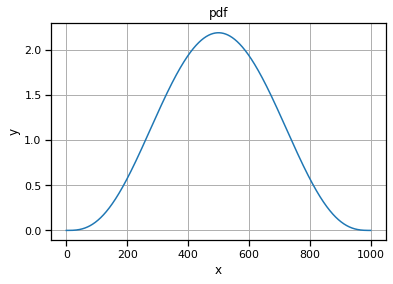

In [73]:
# prior parameters
alpha, beta = 4, 4

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# mean and 95% credible interval
mean = posterior.mean()
cr = posterior.interval(0.95)

# beta distribution for plotting
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

Let's see how we could use it as a model. Its two paramters are pretty special... If we add the number of successes (heads) to $\alpha$ and the number of failures (tails) to $\beta$:

[1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1
 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0
 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1
 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1
 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1
 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0
 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0
 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0
 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 1 

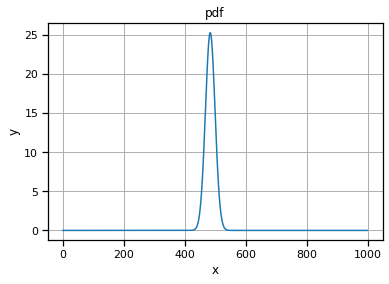

In [77]:
# our events is a list of 0s and 1s, at fixed probabilities
flipcoin = np.random.choice(a= [0, 1],
                              p = [0.5, 0.5],
                              size=1000)
print(flipcoin)
successes = flipcoin.sum()
failures = len(flipcoin) - successes

# prior parameters
alpha, beta = 2, 2

# calculate posterior distribution, using a beta distribution
posterior = stats.beta(alpha + successes, beta + failures)

# mean and 95% credible interval
mean = posterior.mean()
cr = posterior.interval(0.95)
print(cr)

#posterior distribution for plotting
xs = np.linspace(0, 1, num=1000)
pdf = posterior.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

Yup, that looks like the pdf that approximates the probabilities of coin tossing gets *tighter* and *tighter* the more data we have (the more flip coin events we record): The standard deviation keeps getting smaller.

It's a great pdf to use to model priors and posteriors because it can vary smoothly from "*** no idea at all***" to more focused values.

<div style="text-align: right; color: gray">10</div>

## Bayesian inference with the Binomial and the Beta

Models are the mathematical formulation of the observed events. Parameters are the factors in the models affecting the observed data.

Data science is about finding the paramaters, so we can keep the model and throw away the data. All models are **parametric**.

In tossing a coin, **fairness** of a coin may be defined as the parameter denoted by $θ$. The outcome of the events may be denoted by $D$.

What is the probability of 4 heads out of 9 tosses ($D$) given the fairness of coin ($θ$). i.e $p(D|θ)$?

And how about the *converse problem*: Given an outcome (D) what is the probability of the coin being fair ($p(θ)=0.5$)

Let's represent the problem using Bayes Theorem:

$$p(θ|D)=\frac{p(D|θ) \; p(θ)}{p(D)}$$

Here, $p(θ)$ is the **prior** i.e the strength of our belief in the fairness of coin before the toss. It is perfectly okay to believe that coin can have any degree of fairness between 0 and 1.

$p(D|θ)$ is the **likelihood** of observing our result given a belief (value) for θ. For example, if we knew that coin was fair, this gives the probability of observing the number of heads in a particular number of flips.

$p(D)$ is the **evidence**. This is the probability of our data as determined by summing (or integrating) ***across all possible values of θ, weighted by how strongly we believe in those particular values of $θ$***. If we had multiple views of what the fairness of the coin is (but didn’t know for sure), then this tells us the probability of seeing a certain sequence of flips for all possibilities of our belief in the coin’s fairness.

$p(θ|D)$ is the **posterior** belief of our parameters ***after observing the evidence*** i.e the number of heads.

To define our model correctly , we need ***two*** mathematical models:
- One to represent the likelihood function $p(D|θ)$, and 
- The other for representing the distribution of prior beliefs. 

The product of these two gives the posterior belief $p(θ|D)$ distribution.

Let's figure out $p(D|θ)$:

#### $p(y=1|θ) = 0.5$ 
If coin is fair $θ=0.5$, probability of observing heads (y=1) is 0.5.

#### $p(y=0|θ) = 0.5$ 
If coin is fair $θ=0.5$, probability of observing tails (y=0) is 0.5.

<br />

We can combine the above mathematical definitions into a single definition to represent the probability of both outcomes. 
This is called the [Bernoulli Likelihood Function](https://en.wikipedia.org/wiki/Bernoulli_distribution) and the task of coin flipping is called a [Bernoulli trial](https://en.wikipedia.org/wiki/Bernoulli_trial):

$$P(y|θ)= θ^y \; (1-θ)^{1-y}$$ where θ is either 0 or 1.

For many trials, when we observe a *series of heads or flips*, it's a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):

$$p(y_1, y_2, \cdots, y_n \; |\;θ) = \prod_{i=1}^n p(y_i \; |\;θ) = \prod_{i=1}^n θ^y \; (1-θ)^{1-y}$$

The probability of number of heads $z$ turning up in $N$ number of flips ($y=1$ $z$ times for $n = N$, and $y=0$ $N-k$ times in the formula above), is the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) for $N$ trials:

$$p(z, N \; |\;θ) =  θ^z \; (1-θ)^{N-z}$$

This is going to be our **data likelihood function**: What the histogram of our data will look like!

Now, what pdf to use to represent the parameter $\theta$ of our model?

Since prior and posterior are both *beliefs* about the distribution of fairness of coin, intuition tells us that both should have the same mathematical form.

The mathematical function used to represent prior belief $p(\theta)$ ***with uninformative priors*** is the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)!

>**Note**: So-called "**uninformative**" priors for the beta distribution share the property that α=β, leading to a symmetric distribution, and α≤1,β≤1. Common choices are: Uniform (Bayes-Laplace) prior (α=β=1), Jeffreys prior (α=β=1/2), "Neutral" prior (α=β=1/3) proposed by Kerman (2011), Haldane prior (α=β=0), or it's approximation (α=β=ε with ε>0)

If we use the probability density function (pdf) of the beta distribution for $p(\theta)$ as our prior, it can be written as:

$$p(\theta) = \frac{x^{\alpha - 1}\;(1-x)^{\beta - 1}}{B(\alpha, \beta)}$$

$B$ is just to ensure that the total probability density function upon integration evaluates to 1: It's the [beta function](https://en.wikipedia.org/wiki/Beta_function), not to be confused with the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) itself! 

$α$ and $β$ are called the shape-deciding parameters of the density function. Here $α$ is analogous to number of heads in the trials and $β$ corresponds to the number of tails.

$α$ and $β$ are intuitive to understand since they can be calculated by knowing the mean ($μ$) and standard deviation ($σ$) of the beta distribution. They are related as so:

$$μ = \frac{\alpha}{\alpha + \beta}$$

$$σ = \sqrt{\frac{\alpha \; \beta}{(\alpha + \beta)^2\; (\alpha + \beta + 1)}}$$

When there is no toss (no observations yet), we believe that the coin is fair as depicted by the flat line in the first graph below.

When there are tosses (observations) and a bigger number of heads than tails, the graph shows a **peak** shifted towards the *right side*, indicating higher probability of heads, ***and that coin is not fair***.

As more tosses are observed, and tails come in to balance out the heads, the peak narrows and the mean value of the distribution shifts to the middle, increasing our confidence in the fairness of the coin. The images below are the same kinds of images we observede with our coin-tossing simulations above.

</br >
<center>
<img src="ipynb.images/trials-heads.png" width=800 />
</center>

So the beta function appears to be a good choice, since it matches our simulation above with 1,000 coin tosses ($\theta = 0.5$).

It is also similar to the winning distribution of Lewis Hamilton. As the season gets underway, LH may be out of shape and he looses races, and his pdf is skewed towards the losing side, and maybe we don't believe in the power of the Hamilton anymore... But as the season stretches on, LH starts winning again, and his pdf starts shifting towards the winning side, past the mean value for any F1 racer.

So, why did we pick a beta distribution for the prior $p(\theta)$? Because when we multiply it with a likelihood function, posterior distribution yields a form similar to the prior distribution, which is much easier to relate to and understand. So we kind of *cheated*, and it kind of worked out, didn't it? 

Calculating **posterior belief** using Bayes theorem and the binomial distribution and beta distributions as depicted above:

$$p(θ\;|\;z, N) = \frac{p(z,N\;|\;θ) \; p(θ)}{p(z,N)}$$

$$p(θ\;|\;z, N) = \frac{θ^z \; (1-θ)^{N-z} \; θ^{\alpha - 1} \; (1-θ)^{\beta - 1}} {B(\alpha, \beta)\; p(z,N)}$$

$$p(θ\;|\;z, N) = p(θ\;|\;z + \alpha, N - z + \beta) $$

So the posterior is also a beta function, *with shifted arguments*.

So, just knowing the mean $\mu$ and standard deviation $\sigma$ (and thus $\alpha$ and $\beta$) of our prior belief $p(θ)$ and by observing the number ($z$) of heads in $N$ flips, we can *easily* update our belief (that's our ***posterior***) about the model parameter $θ$. All ***analytically***!

## An experiment in bias
Here's a data experiment: Suppose, you think that a coin is **biased**. It has a mean ($μ$) bias of around 0.6 with standard deviation of 0.1 (so it's not *fair*!).

Then from the formulas above,

$α$= 13.8 , $β$=9.2

and our distribution is biased on (*skewed towards*) the *right side*. 

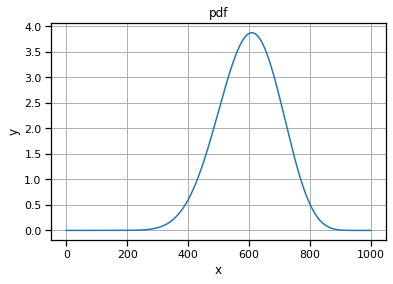

In [78]:
# prior parameters
alpha, beta = 13.8, 9.2

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# mean and 95% credible interval
mean = posterior.mean()
cr = posterior.interval(0.95)

# beta distribution for plotting
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

Suppose now you observe 80 heads ($z=80$) in 100 flips($N=100$). We have our **before** and **after**, let’s compute our prior and posterior beliefs:

**prior** = $p(θ\;|\;α,β) = p(θ\;|\;13.8,9.2)$

**posterior** = $p(θ\;|\;z+α,N-z+β) = p(θ\;|\;93.8,29.2)$

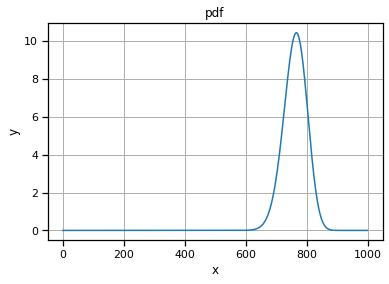

In [79]:
# prior parameters
alpha, beta = 93.8, 29.2

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# mean and 95% credible interval
mean = posterior.mean()
cr = posterior.interval(0.95)

# beta distribution for plotting
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

As more and more flips are made and new data is observed, our beliefs get **updated**, meaning we get new probabilities and our confidence increases (standard deviation decreases). ***This is the power of Bayesian Inference***.


If you don't care about flipping coins, think about F1. As the F1 season gets  under way, LH may be in not-so-good shape and *loose* a few races before getting in shape and winning again. His pdf, at the end of the season, we know is skewed towards winning, but at the start of the season, that may not be the case. As the season progresses and new evidence comes in (LH wins), the LH pdf sharpens into the pdf we expect from LH from past seasons.

>***You*** decide: In a **frequentist** world view, data observed is considered **random**, but model parameters are considered **fixed**. How is that possible when our belief about the magic of the Hamilton changes depending on the number of his wins in the current F1 season? *Soooooooo wrong*! Our model parameters *cannot* be fixed! In a **Bayesian** World view, data is considered **fixed** and model parameters are treated as **random variables** with probability distributions. I *liiiiiiiiike that*!


### Bayes factor

The [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) is the equivalent of [p-value](https://en.wikipedia.org/wiki/P-value) in the Bayesian framework.

When $θ$ is the probability LH wins the F1 overall trophy for the season, a **null hypothesis** in a Bayesian framework would assume $∞$ probability distribution *only* at a particular value of a parameter (say $θ=0.5$) and a zero probability elsewhere. The **alternative hypothesis** could be that ***all values of $θ$ are possible***, hence a **flat curve** representing the distribution. That's what we start with at the beginning of the F1 season: we have no idea if LH is going to win. It's 50-50.

As the season gets underway, Bayesian statistics adjust credibility (probability) of of $θ$ as we observe more data (F1 grand prix results). It can be seen that the probability distribution for LH is shifting towards the **alternative hypothesis** with a value higher than the **null hypothesis**. i.e. the alternative hypothesis is likely: We have higher and higher conviction that LH is going to win the season.

Bayes factor does not depend upon the actual distribution values of $θ$, but only the magnitude of the shift in values for each hypothesis.

In panel A below: left bar is the prior probability of the **null hypothesis** and the right bar the probability of the **alternative hypothesis**. Same as in panel B, but the bars have different shapes. F1 season starts and ***we don't know who's going to win*** (prior). As the season progresses, probability that LH wins gets higher and higher (posterior).

</br >
</br >
<center>
<img src="ipynb.images/prior-posterior.png" width=600 />
</center>

**Bayes factor** is defined as the ratio of the odds of the two hypotheses at any moment in time (prior or posterior):

$$BF = \frac{p(NH\;|\;z, N)}{p(AH\;|\;z, N)}$$

Where $NH$ represents the **null hypothesis** and $AH$ the **alternative hypothesis**.

To reject a null hypothesis, a $BF < 0.1$ is *preferred*. The immediate benefits of using the **Bayes Factor** instead of **p-values** is that the BF is **independent of intentions and sample size**.

### High Density interval (HDI)

The **High Density Interval** (HDI) is formed from the **posterior distribution** after observing new data (e.g. more F1 grand prix results). 

Since HDI is a probability, the 95% HDI gives the 95% most credible values for your test statistic. It is also guaranteed that 95% values will lie in this interval.

This interval is often plotted bounded by two numbers, which represent how many simulations end up outside that interval, either to the right or to the left.

Notice how the 95% HDI in prior distribution is wider than the 95% posterior distribution. This is because our belief in HDI increases upon observation of new data:

Read more about the HDI [here](https://www.sciencedirect.com/topics/mathematics/highest-density-interval).

</br>
</br >
<center>
<img src="ipynb.images/hdi.png" width=400 />
</center>

Here's how to compute the ***Bayesian*** probability that a drug works p(AH), ites effect, and **confidence range**, when your delta is a **probability distribution**:
```
p  =  np.mean(delta  >  0)
effect  =  np.mean(delta)
CR  =  np.percentile(delta, (2.5, 97.5))
```

<div style="text-align: right; color: gray">11</div>

# 7. Experiment 2: Horny Boston Sloths

Let's run an experiment using Bayesian estimation, and a ***new*** probabilistic library: `Sampyl`.

We want to compare the number of times Boston sloths become **romantic** after we introduce a new drug that is supposed to be a sloth [aphrodisiac](https://en.wikipedia.org/wiki/Aphrodisiac). Does it work?. We have a **before** and **after** distribution of how many times a week sloths engage in romantic acts. So we have a [bivariate](https://en.wikipedia.org/wiki/Function_(mathematics)#Multivariate_function) data experiment (`before` and `after` parameters). 

</br >
<center>
<img src="images/slothskissing.jpg" width=700 />
</center>

Instead of using classical frequentist statistical estimation theory, we'll use a **Bayesian model**. That means that instead of finding model parameters as **point estimates**, we'll identify model parameters as **pdfs**.

Consider an indexed collection of random variables $y_{1},\ldots ,y_{n}$. The joint probability distribution for $y_1, y_2, \ldots$ is a probability distribution that gives the probability that each of $y_1, y_2, \ldots$ falls in any particular range or discrete set of values specified for that variable. 

What are the right values for the parameters of our model, given the observations?

Using Bayes:

$$p(\theta \; | \; (y_i)_{i=1}^n) = \prod_{i = 1}^n p(y_i \; | \; \theta) . p(\theta)$$

Let's build a Bayesian model using a [**Poisson**](https://en.wikipedia.org/wiki/Poisson_distribution) likelihood with **exponential** priors for $\lambda_1$ and $\lambda_2$. 

>Ok, what does *that* mean, professor? 

That means we assume sloth acts of romance ($R$) per week are bunched up around a certain statistic, per Poisson, before ($\lambda_1$) and another statistic after ($\lambda_2$), and we are going to traverse $\lambda$ state space ***exponentially*** to try to locate the best $\lambda$s (the best parameters for our *before* and *after* Poissons). 

Let's recap: 
- Our model is a **Poisson** pdf
- The model parameter is $\lambda$
- We have two models (thus two parameters): before aphrodisiac, and after
- We want to find the optimal values of the parameters
- Since we're dealing with Bayesian statistics, we'll model these two parameters as pdfs
- Our walks through state space to find solutions for the parameters will be exponential (not in speed, but in trajectory). 

By Bayes' law:

$$
p(\lambda_1, \lambda_2 \mid R) \;\propto p( R \mid \lambda_1, \lambda_2)\, p(\lambda_1)\, p(\lambda_2) \;\;\; \text{(no denominator!)}\\
p( R \mid \lambda_1, \lambda_2) \;\sim \mathrm{Poisson}(R\mid\lambda_1)\,\mathrm{Poisson}(R\mid\lambda_2) \\
p(\lambda_1) \;\sim \mathrm{Exp}(\lambda) \\
p(\lambda_2) \;\sim \mathrm{Exp}(\lambda) 
$$

This analysis method we'll follow is known as `Bayesian estimation` using probabilistic programming. 

We have the equations above,and we want to know *likely* values for $\lambda_1$ and $\lambda_2$. This information is contained in the posterior distribution $p(\lambda_1, \lambda_2 \mid R)$. To infer values for $\lambda_1$ and $\lambda_2$, we sample from the posterior using MCMC samplers. Let's use the [Metropolis](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm. No more math! *Programming*, instead!

<div style="text-align: right; color: gray">12</div>

## Sampyl

`PyMC3` is not the only MCMC package. `Sampyl` is another, simpler one. You can [eead](https://pypi.org/project/sampyl-mcmc/) about it. [Here](http://matatat.org/sampyl/introduction.html) too. Let's install it. Better use an Anaconda terminal. If that does not work, try the below.

In [ ]:
!pip install sampyl-mcmc

We don't have data for romantic adventures of Boston sloths! So, we ***make up the data*** using two Poisson distributions, one with parameter 7 (before aphrodisiac), the other with parameter 9 (after aphrodisiac). So, we're cheating!

(yes, professor can do that, ***you cannot*** :-)

(array([5., 7., 8., 5., 2., 5.]),
 array([ 3.,  5.,  7.,  9., 11., 13., 15.]),
 <a list of 6 Patch objects>)

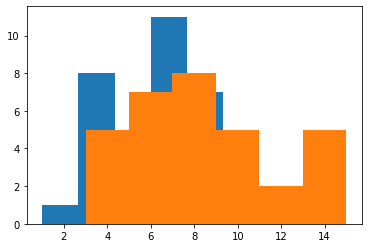

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Fake data for the day before and after aphrodisiac introduction into Boston sloth population
# Let's be conservative and assume that the aphrodisiac will increase acts of romance by 2 per week. Let's record data weekly.
before = np.random.poisson(7, size=32)
after = np.random.poisson(9, size=32)
plt.hist(before, bins='auto')
plt.hist(after, bins='auto')

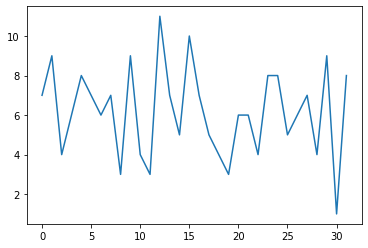

In [4]:
plt.plot(before)

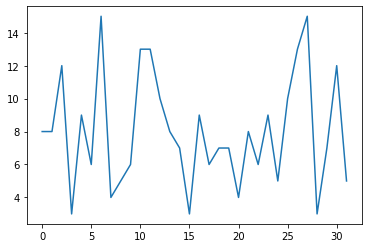

In [5]:
plt.plot(after)

In [6]:
# Define the log-P function here
def logp(λ1, λ2):
    model = smp.Model()
    # Poisson log-likelihoods
    model.add(smp.poisson(before, rate=λ1),
              smp.poisson(after, rate=λ2))

    # Exponential log-priors for rate parameters
    model.add(smp.exponential(λ1),
              smp.exponential(λ2))
    
    return model()

Let's MCMC-simulate with `Sampyl`. We seed our starting condition with point estimates from the classical method called **M**aximum **A** **P**osteriori estimation (MAP). It's pretty similar to MLE.

Then we say simulate for 10,000 timesteps and throw away the first 2,000 timesteps. Then give us statistical results of our simulation.

In [9]:
import sampyl as smp
from sampyl import np
    
start  =  smp.find_MAP(logp, {'λ1':1., 'λ2':1.})
sampler = smp.Metropolis(logp, start)
chain = sampler(10000, burn=2000, thin=4)

d:\Anaconda3.5.1\lib\site-packages\sampyl\state.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(self.values())
d:\Anaconda3.5.1\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
d:\Anaconda3.5.1\lib\site-packages\sampyl\state.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(self.values())


Progress: [##############################] 10000 of 10000 samples


In [85]:
sampler. #sampler - DOT - TAB

SyntaxError: invalid syntax (<ipython-input-85-96aa702780c0>, line 1)

In [10]:
print(sampler.var_names)

('λ1', 'λ2')


These are the **values** of the two $\lambda$s we simulated (the *values*, not the *pdf$s for each):

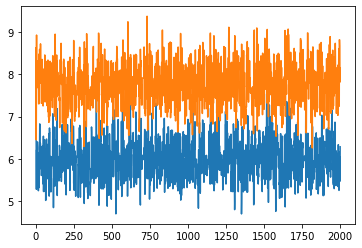

In [11]:
plt.plot(chain.λ1)
plt.plot(chain.λ2)

Now to see if there is a significant difference between **before aphrodisiac** and **after aphrodisiac**, we can look for the **difference** $\delta =  \lambda_2 - \lambda_1$, then find the probability that $\delta > 0$. Now let's find the pdf for $\delta$ by plotting the histogram of the difference between the simulated values of $\lambda_1$ and $\lambda_2$, and let's also plot a vertical line at $\delta = 2$ because we ***know that the difference between the two $\lambda$s should be 2***!

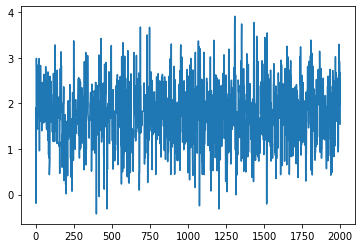

In [12]:
plt.plot(chain.λ2 - chain.λ1)

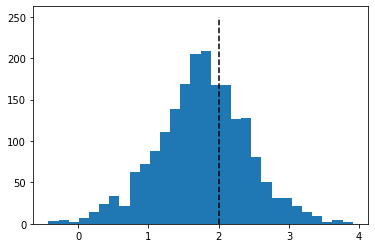

In [13]:
delta  = chain.λ2  - chain.λ1
_ =  plt.hist(delta, bins=30)
_ =  plt.vlines(2,  0,  250,  linestyle = '--')

Pretty close, huh?! 

Let's compute the probability that acts of romance ***increased***: the difference between the means of `before` and `after`, and our confidence interval.

In [14]:
p  =  np.mean(delta  >  0)
effect  =  np.mean(delta)
CR  =  np.percentile(delta, (2.5, 97.5))
print("{:.3f} probability the rate of acts of romance increased".format(p))
print("delta = {:.3f}, 95% CR = {{{:.3f} {:.3f}}}".format(effect, *CR))

0.995 probability the rate of acts of romance increased
delta = 1.764, 95% CR = {0.440 3.045}


Wow, we are ***almost sure*** the acts of romance increased!

And what's the size of the difference? About 2.5 for a 95% confidence interval, where the true value lies in the intereval [1.17, 4].

The true difference in rates was two per hour, marked with the dashed line. We got it right!

Our posterior is showing an effect, and our best estimate is that the rate increased by about 2.5 acts of romance per week. The 95% credible region is [1.663 2.327] which idicates that there is a 95% probability that the true effect lies with the region, as it does.

To use the [NUTS](https://en.wikipedia.org/wiki/Stan_(software)#Algorithms) algorithm to sample from the posterior instead of Metropolis:
```
nuts = smp.NUTS(logp, start)
chain = nuts.sample(2100, burn=100)
_ = plt.plot(chain.λ1)
_ = plt.plot(chain.λ2)
```
(but you may have to install autograd).

followed by:
```
delta = chain.λ2 - chain.λ1
_ = plt.hist(delta, bins=30)
_ = plt.vlines(2, 0, 250, linestyle='--')
p = np.mean(delta > 0)
effect = np.mean(delta)
CR = np.percentile(delta, (2.5, 97.5))
print("{:.3f} probability the rate of weekly romantic acts increased".format(p))
print("delta = {:.3f}, 95% CR = {{{:.3f} {:.3f}}}".format(effect, *CR))
```

# 8. Conclusion

What's the **model** for the data you observe? That's the ***science*** of the statistician. You need to pick the right one by eyeballing the histogram. It's the same in Machine Learning (ML): You need to pick the right model (CNN, RNN, etc.).

The likelihood function you pick will tell you how many parameters. What are the shapes of the pdf for each parameter of your model? That's the ***art*** of the statistician. 

In **classical statistical estimation**, model parameters are **point estimates** (like with MOM or MLE), and if you want an error range, you need to do voodoo math like the **T-test**. 

In **Bayesian statistical estimation**, parameters are ***pdf***s so that an algorithm can find likely values and thus naturally also yield the most probable value (the mean of the pdf) *and* its error (the standard deviation of the pdf).